# A Resnet Variant for Gomoku

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import datetime as dt
import random

import numpy as np
import tensorflow as tf
import keras
from keras import layers

from aegomoku.game_data import read_training_data, create_dataset
import keras.initializers.initializers_v2 as initializers
from aegomoku.policies.primary_detector import PrimaryDetector

from setup_local import DATA_PATH

# Training on Terminal Opportunities
Let's start easy. Terminal threats are lines of 4 with at least one open end. These positions MUST be taken or the opponent's next move terminates the game in her favor.

# Selfplay files contain training data

file = examples, games

examples = list(board, policy, value)

games = list(list(moves))

In [36]:
BOARD_SIZE=19
filename = DATA_PATH / 'selfplay' / '0' / '00001.pickle'
examples, games = read_training_data(filename)

In [37]:
len(examples), len(examples[0]), examples[0][0].shape, np.array(examples[0][1]).shape, examples[0][2]

(12112, 3, (21, 21, 3), (361,), 0.047885932843200855)

£# Trainable components combined with a heuristic *advisor*
Actually, it's boring feature engineering, what we're doing here. And yes that's exactly why this is **Alpha Epsilon** - not quite **Alpha Zero**: We induce a little *bias* by providing knowledge about the most critical positions

In [38]:
inputs = keras.Input(shape=(21, 21, 3), name="inputs")

In [43]:
def xp(n, filters, kernel):
    return layers.Conv2D(
        name=f"expand_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [44]:
def ct(n, filters, kernel):
    return layers.Conv2D(
        name=f"contract_{n}_{kernel}x{kernel}",
        filters=filters, kernel_size=kernel,
        kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
        bias_initializer=tf.constant_initializer(0.),
        activation=tf.nn.softplus,
        padding='same')

In [45]:
policy_aggregate = layers.Conv2D(
    name="policy_aggregator",
    filters=1, kernel_size=1,
    kernel_initializer=initializers.TruncatedNormal(seed=1, stddev=0.08),
    bias_initializer=tf.constant_initializer(0.),
    activation=tf.nn.relu,
    padding='same')

In [46]:
peel = layers.Conv2D(
    name="border_off",
    filters=1, kernel_size=(3, 3),
    kernel_initializer=tf.constant_initializer([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]]),
    bias_initializer=tf.constant_initializer(0.),
    padding='valid',
    trainable=False)

In [47]:
advisor = PrimaryDetector(BOARD_SIZE, activation=tf.keras.activations.tanh, name='heuristics')

In [50]:
features = advisor(inputs)

#features=tf.keras.activations.tanh(features)
x = xp(1, 256, 11)(inputs)
c = ct(1, 4, 5)(x)

value_input_from_sensor = None
c1 = None
for i in range(2, 11):
    i1 = layers.concatenate([features, c], axis=-1)
    if i == 2:
        value_input_from_sensor = i1
    x1 = xp(i, 32, 5)(i1)
    c1 = ct(i, 4, 3)(x1)
    c = layers.Add(name=f"skip_{i}")([c1, c])

value_input_from_head = c1

value_input = layers.concatenate([value_input_from_head, value_input_from_sensor],
                                 name='all_value_input', axis=-1)
value_flat = layers.Flatten(name='flat_value_input')(value_input)
value = layers.Dense(1, name="value_head", activation=tf.keras.activations.tanh)(value_flat / 100.)

x = policy_aggregate(c)
y = peel(x)
flatten = layers.Flatten(name="flat_logits")(y)
policy = layers.Softmax(name="policy_head")(flatten)
model = keras.Model(inputs=inputs, outputs=[policy, value])
model.compile()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 21, 21, 3)]  0           []                               
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 21, 21, 256)  93184       ['inputs[0][0]']                 
                                                                                                  
 heuristics (PrimaryDetector)   (None, 21, 21, 5)    113288      ['inputs[0][0]']                 
                                                                                                  
 contract_1_5x5 (Conv2D)        (None, 21, 21, 4)    25604       ['expand_1_11x11[0][0]']         
                                                                                            

---



# Policy Output of the Untrained Model
From experience we can tell that the training will most likely succeed when we see some structured output here. For unknown reasons, some architectures initialize such that the untrained network produces a flat policy output.

In [68]:
n = random.randint(0, 100)
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p, v = model(sample)
print((np.squeeze(p)*999).astype(np.uint8))
print(f"Value = {np.squeeze(v)}")

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  1  1  1  1  1  1  2  1  1  1  0  0  0  0  0  0  0  0  0  1
  5  3  6  1  2  2  4  1  2  1  0  0  0  0  0  0  0  1  2  2  7  5  3  2
  5  3 36  2  1  0  0  0  0  0  0  0  3  3 51  3 12  1  3  7 34  2  1  0
  0  0  0  0  0  0  0  1 62  5 36  9  9 13  0  9  5  2  0  0  0  0  0  0
  0  0  3  8  0 16  0 74  0 57  5  3  1  0  0  0  0  0  0  0  0  1  3  6
  0  0  0 25 15  3  2  0  0  0  0  0  0  0  0  0  1  2  2  3  0  7 42  9
  2  1  0  0  0  0  0  0  0  0  0  1  1  2  2  6 60 11 37  2  1  0  0  0
  0  0  0  0  0  0  0  0  1  1  5  2  9  2  2  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

---

# Training

In [52]:
policy_loss = tf.keras.losses.CategoricalCrossentropy()
value_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [53]:
train_probs_metric = tf.keras.metrics.Mean('train_probs', dtype=tf.float32)
train_value_metric = tf.keras.metrics.Mean('train_value', dtype=tf.float32)

def train(train_examples, epochs_per_train=100, report_every=100):
    current_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    all_train_ds = create_dataset(train_examples)

    for epoch in range(epochs_per_train):
        for x_train, pi_train, v_train in all_train_ds:
            train_step(x_train, pi_train, v_train)
        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', train_probs_metric.result(), step=epoch)

        if epoch % report_every == 1:
            print(f'Epoch: {epoch}, Training: '
                  f'{train_probs_metric.result().numpy(), train_value_metric.result().numpy()}')

    print(f'Epoch: {epochs_per_train}, Training: '
          f'{train_probs_metric.result().numpy(), train_value_metric.result().numpy()}')

    train_probs_metric.reset_states()
    train_value_metric.reset_states()

@tf.function
def train_step(x, pi_y, v_y):
    with tf.GradientTape() as tape:
        probs, value = model(x, training=True)
        train_loss_p = policy_loss(pi_y, probs)
        train_loss_v = value_loss(v_y, value)
        total_loss = train_loss_p + train_loss_v

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_probs_metric(train_loss_p)
    train_value_metric(train_loss_v)

In [59]:
N = 2000
train(examples[:N], epochs_per_train=20, report_every=5)

Epoch: 1, Training: (5.063764, 0.057916272)
Epoch: 6, Training: (4.9842367, 0.057147637)
Epoch: 11, Training: (4.9123397, 0.056488156)
Epoch: 16, Training: (4.845821, 0.055918377)
Epoch: 20, Training: (4.8085923, 0.055610362)


In [84]:
N = 5000
train(examples[:N], epochs_per_train=200, report_every=20)

Epoch: 1, Training: (4.094463, 0.056391973)


KeyboardInterrupt: 

---
# Convincing Performance on Unseen Examples
With loss values below 1.2 we already have sufficient performance on the terminal threat dataset. Sufficient means that if there's only one terminal threat on the board, the policy will include it, at least among other moves that the tree search can then easily rule out.

In [81]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_, v_ = model(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")


n=11395


Next to play: WHITE
Value from WHITE's point of view: -0.0132095105946064


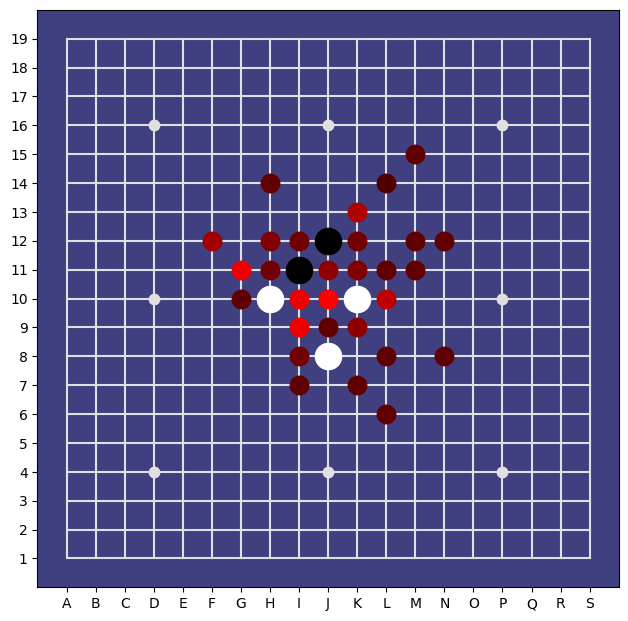

In [82]:
analyse_example(examples[n])

Next to play: WHITE
Value from WHITE's point of view: 0.059028662741184235


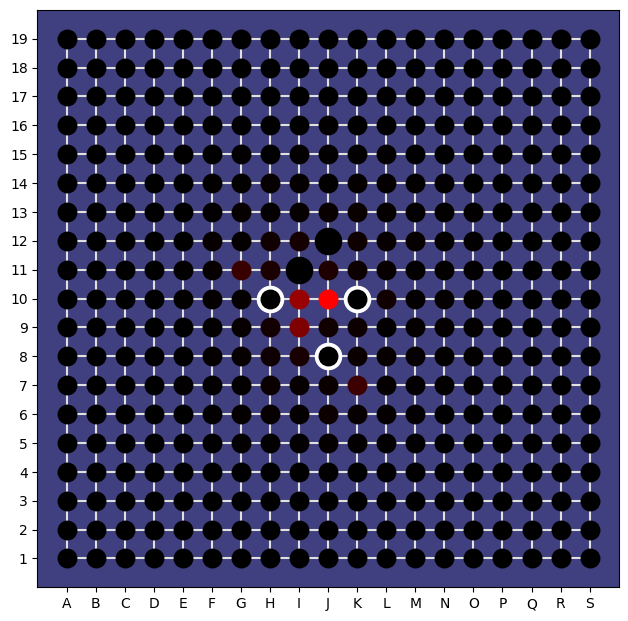

In [83]:
analyse_example(example)

---

# All of that is now in GomokuResnet

In [ ]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(board_size=15, num_blocks=20, num_sensor_filters=1024)
model.summary()

In [ ]:
N=2000
from aegomoku.trainer import Trainer
trainer = Trainer(model)
ds = create_dataset(examples[:N], batch_size=1024)
trainer.train(ds, epochs_per_train=400, report_every=20)

In [ ]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)

p_, v_ = model(sample)
s, _, _ = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)

In [35]:
N = 2000
train(examples[:N], epochs_per_train=20, report_every=5)

Epoch: 1, Training: (6.9867935, 0.17791544)
Epoch: 6, Training: (5.462475, 0.11557042)
Epoch: 11, Training: (5.1319084, 0.093506575)
Epoch: 16, Training: (4.9386806, 0.08397129)
Epoch: 20, Training: (4.821642, 0.080846444)


In [36]:
N = 5000
train(examples[:N], epochs_per_train=200, report_every=20)

Epoch: 1, Training: (3.6373208, 0.050578486)
Epoch: 21, Training: (1.6471745, 0.05105175)
Epoch: 41, Training: (1.3100998, 0.049909636)
Epoch: 61, Training: (1.1562135, 0.04887081)
Epoch: 81, Training: (1.0642339, 0.048209924)
Epoch: 101, Training: (1.0089085, 0.047772605)
Epoch: 121, Training: (0.9672268, 0.047380496)
Epoch: 141, Training: (0.93623513, 0.047050513)
Epoch: 161, Training: (0.912019, 0.04674411)
Epoch: 181, Training: (0.89248013, 0.046477113)
Epoch: 200, Training: (0.87816817, 0.046243556)


---
# Convincing Performance on Unseen Examples
With loss values below 1.2 we already have sufficient performance on the terminal threat dataset. Sufficient means that if there's only one terminal threat on the board, the policy will include it, at least among other moves that the tree search can then easily rule out.

n=19884
Next to play: WHITE
Value from WHITE's point of view: -0.5143582048153265
Next to play: WHITE
Value from WHITE's point of view: -0.42720162868499756


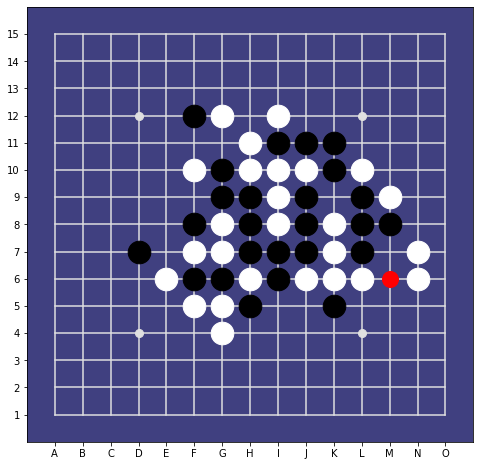

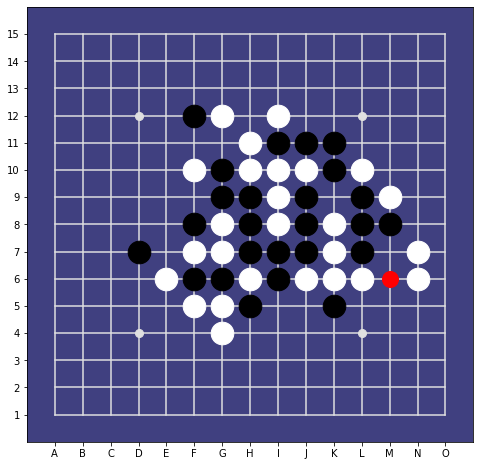

In [57]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_, v_ = model(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)

---

# All of that is now in GomokuResnet

In [4]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(board_size=15, num_blocks=20, num_sensor_filters=1024)
model.summary()

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
2022-08-21 07:54:14.712540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 07:54:14.713215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-21 07:54:14.718636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (

Model: "gomoku_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 17, 17, 3)]  0           []                               
                                                                                                  
 heuristic_detector (Conv2D)    (None, 17, 17, 307)  111748      ['inputs[0][0]']                 
                                                                                                  
 expand_1_11x11 (Conv2D)        (None, 17, 17, 1024  372736      ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 heuristic_priority (Conv2D)    (None, 17, 17, 5)    1540        ['heuristic_detector[

In [5]:
N=2000
from aegomoku.trainer import Trainer
trainer = Trainer(model)
ds = create_dataset(examples[:N], batch_size=1024)
trainer.train(ds, epochs_per_train=400, report_every=20)

2022-08-21 07:54:27.549320: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-21 07:54:27.780545: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 1, Training: (5.0408435, 0.20604649) - elapsed: 8.189270142000169s
Epoch: 21, Training: (3.7192786, 0.075238235) - elapsed: 13.44873130400083s
Epoch: 41, Training: (2.7031546, 0.06755585) - elapsed: 13.526480253000045s
Epoch: 61, Training: (2.142976, 0.06454063) - elapsed: 13.56964555599916s
Epoch: 81, Training: (1.8195319, 0.06285138) - elapsed: 13.906993277998481s
Epoch: 101, Training: (1.6137385, 0.061638992) - elapsed: 14.231972757999756s
Epoch: 121, Training: (1.4783899, 0.06071533) - elapsed: 14.245046777001335s
Epoch: 141, Training: (1.37802, 0.059855804) - elapsed: 14.008861115999025s
Epoch: 161, Training: (1.2995623, 0.058757298) - elapsed: 14.01311456700023s
Epoch: 181, Training: (1.2396085, 0.057219688) - elapsed: 13.756060480000087s
Epoch: 201, Training: (1.1921237, 0.0550034) - elapsed: 13.690853689000505s
Epoch: 221, Training: (1.1526363, 0.052167967) - elapsed: 14.220607059998656s
Epoch: 241, Training: (1.1190438, 0.049082126) - elapsed: 14.495237629000258s
Epoch:

n=14445
Next to play: WHITE
Value from WHITE's point of view: -0.4938125253615174
Next to play: WHITE
Value from WHITE's point of view: -0.42351463437080383


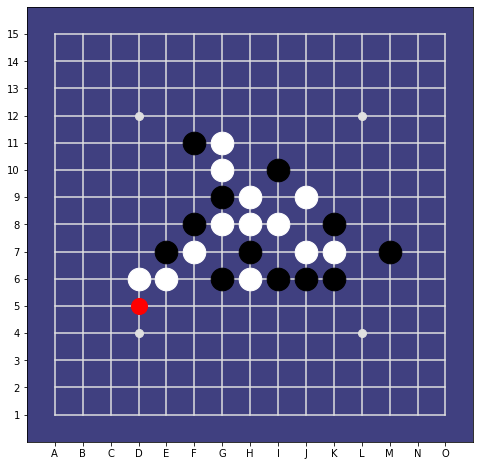

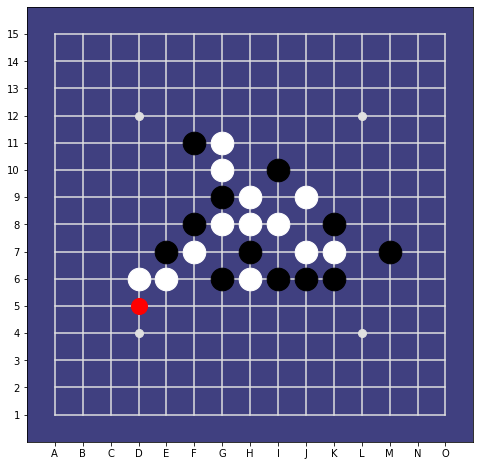

In [29]:
from aegomoku.utils import analyse_example

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)

p_, v_ = model(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)